# Libraries

In [1]:
import os
import sys
import pickle
import datetime, time
import random
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_paths = {os.pardir}  # package directory
sys.path.extend(module_paths.difference(sys.path))

from nytf import utils, main_pipeline; reload(main_pipeline); reload(utils)
pass

# Loading dataframes

In [2]:
%%time
train = utils.load_dataframe('train')  #, extension='csv', save_pkl=True)
test = utils.load_dataframe('test')  #, extension='csv', save_pkl=True)

Wall time: 2.27 s


In [3]:
main_pipeline.main_pipeline.fit_transform(train.iloc[:10000])

RuntimeError: Cannot clone object BasicTemporalFeatures(feature_names=['timestamp', 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'days_in_month', 'is_leap_year', 'day_progress', 'week_progress', 'month_progress', 'year_progress']), as the constructor either does not set or modifies parameter feature_names

In [5]:
est = utils.BasicTemporalFeatures()

In [8]:
est.set_params(feature_names = 1)

BasicTemporalFeatures(feature_names=1)

In [57]:
train.memory_usage().sum()/10**9  # In Go

1.99901713

In [68]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500000,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.900000,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.700000,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.700000,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.300000,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1
5,12.100000,2011-01-06 09:50:45+00:00,-74.000961,40.731628,-73.972893,40.758232,1
6,7.500000,2012-11-20 20:35:00+00:00,-73.980003,40.751663,-73.973801,40.764843,1
7,16.500000,2012-01-04 17:22:00+00:00,-73.951302,40.774139,-73.990097,40.751049,1
8,9.000000,2012-12-03 13:10:00+00:00,-74.006462,40.726711,-73.993080,40.731628,1
9,8.900000,2009-09-02 01:11:00+00:00,-73.980659,40.733871,-73.991539,40.758137,2


In [59]:
test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12+00:00,-73.960983,40.765549,-73.979179,40.740051,1
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20+00:00,-73.949013,40.773205,-73.959625,40.770893,1
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20+00:00,-73.777283,40.646637,-73.985085,40.759369,1
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20+00:00,-74.014099,40.709637,-73.995110,40.741364,1
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20+00:00,-73.969582,40.765518,-73.980682,40.770725,1


# Exploration of fare_amount

There are 0 NaN in train


count    5.542386e+07
mean     8.077921e+00
std      2.055127e+01
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.396336e+04
Name: fare_amount, dtype: float64

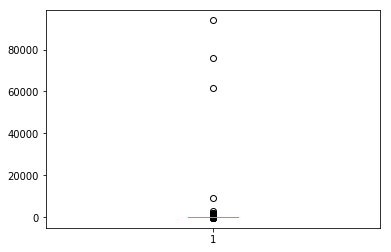

In [5]:
# Very big std...
# Maybe there are some outlayers
plt.boxplot(train.fare_amount)
print('There are {} NaN in train'.format(train.fare_amount.isna().sum()))
train.fare_amount.describe()

The number of fare_amount not in [0,100] is 23329.


count    5.542386e+07
mean     8.061326e+00
std      9.643700e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.000000e+02
Name: fare_amount, dtype: float64

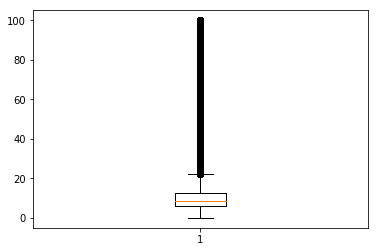

In [6]:
# We can for example clip values in [clip_min,clip_max] and obtain a more reasonable std of 9.6$
clip_min = 0
clip_max = 100

fare_cliped = train.fare_amount.clip(clip_min, clip_max)
plt.boxplot(fare_cliped)
print('The number of fare_amount not in [{},{}] is {}.'.format(clip_min, clip_max, (train.fare_amount < clip_min).sum() + (train.fare_amount > clip_max).sum()))
fare_cliped.describe()

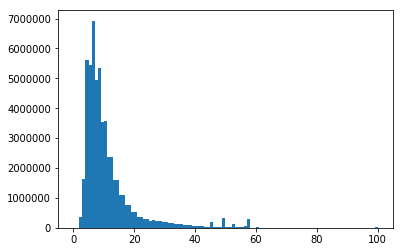

In [7]:
# This is better.
# Most part of fares are in [0, 65].
# It is probably safer to drop outlayers than clip it.
plt.hist(fare_cliped, bins=100)
pass

# Exploration of passenger_count

In [8]:
# Some outlayers: 7, 8, 9, 34, 49, 51, 128 (-127 in int8), 208 (-48 in int8) and maybe 0.
# No NaN, but 0 may be considered has it.
# Pertinent featurs seems to be dataframe.passenger_count>=i for i in range(1, 7) or range(2, 7) if 0 is drop.
# It is safer to drop outlayers.
# There is a similare frequencies in train and test

counts = pd.DataFrame({
    'train': train.passenger_count.value_counts(dropna=False),
    'test': test.passenger_count.value_counts(dropna=False),
    'train_freq': train.passenger_count.value_counts(dropna=False, normalize=True),
    'test_freq': test.passenger_count.value_counts(dropna=False, normalize=True)}
).fillna(0)
counts.test = counts.test.astype('int')
counts

,train,test,train_freq,test_freq
-127,2,0,3.608554e-08,0.000000
-48,64,0,1.154737e-06,0.000000
0,195416,0,3.525846e-03,0.000000
1,38337524,6914,6.917152e-01,0.697398
2,8175243,1474,1.475040e-01,0.148679
3,2432712,447,4.389287e-02,0.045088
4,1178852,206,2.126976e-02,0.020779
5,3929346,696,7.089629e-02,0.070204
6,1174647,177,2.119389e-02,0.017854
7,15,0,2.706416e-07,0.000000


# Exploration of lat long

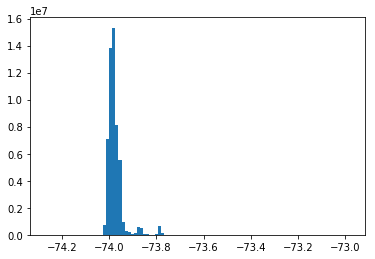

In [43]:
plt.hist(train.pickup_longitude[(-74.27 < train.pickup_longitude) & (train.pickup_longitude < -72.98)], bins=100)
pass

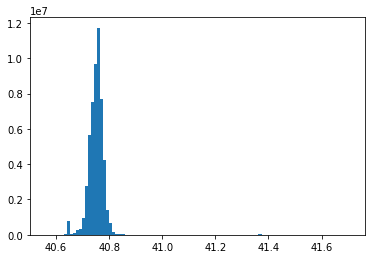

In [46]:
plt.hist(train.pickup_latitude[(40.56 < train.pickup_latitude) & (train.pickup_latitude < 41.71)], bins=100)
pass

In [48]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273
std,0.042799,0.033542,0.039093,0.035436,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


# Exploration of pickup_datetime

2012    8919666
2011    8841346
2013    8655190
2009    8543166
2010    8354997
2014    8252682
2015    3856809
Name: pickup_datetime, dtype: int64

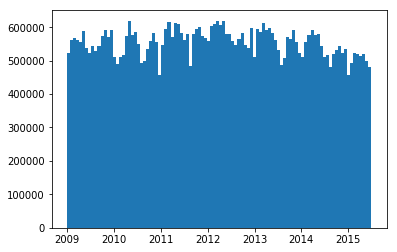

In [9]:
# There is no outlayer for train, years are in [2009, 2015]
plt.hist(train.pickup_datetime, bins=100)
train.pickup_datetime.apply(getattr, args=('year',)).value_counts(dropna=False)

2011    2050
2014    1902
2010    1753
2012    1433
2013    1135
2009    1022
2015     619
Name: pickup_datetime, dtype: int64

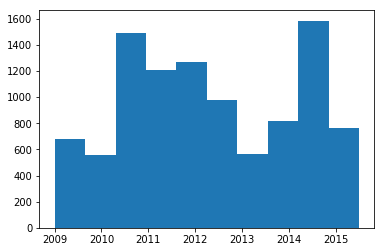

In [10]:
# There is no outlayer for test, years are in [2009, 2015], it is in the same periode than train.
plt.hist(test.pickup_datetime, bins=10)
test.pickup_datetime.apply(getattr, args=('year',)).value_counts(dropna=False)

In [11]:
# To conclude it seems that test and train was obtain by an uniforme spliting on a same dataframe
# with a cleaning of outlayers for test

# Exploration of temporal features

In [12]:
%%time
temporal_features = utils.BasicTemporalFeatures().transform(train.pickup_datetime)

Wall time: 3min 37s


In [13]:
temporal_features.memory_usage().sum()/10**9  # In Go

1.718139616

In [14]:
temporal_features

,timestamp,minute,hour,day,month,year,dayofweek,dayofyear,days_in_month,is_leap_year,day_progress,week_progress,month_progress,year_progress
0,1245086781,26,13,15,6,2009,0,166,30,False,0.559722,0.079960,0.485324,0.453588
1,1262710336,52,11,5,1,2010,1,5,31,False,0.494444,0.213492,0.144982,0.012314
2,1313627700,35,20,17,8,2011,2,229,31,False,0.857639,0.408234,0.543795,0.627007
3,1334982642,30,0,21,4,2012,5,112,30,True,0.020833,0.717262,0.667361,0.303336
4,1268121060,51,2,9,3,2010,1,68,31,False,0.118750,0.159821,0.261895,0.183887
5,1294307445,50,4,6,1,2011,3,6,31,False,0.201389,0.457341,0.167787,0.014250
6,1353443700,35,15,20,11,2012,1,325,30,True,0.649306,0.235615,0.654977,0.887020
7,1325697720,22,12,4,1,2012,2,4,31,True,0.515278,0.359325,0.113396,0.009605
8,1354540200,10,8,3,12,2012,0,338,31,True,0.340278,0.048611,0.075493,0.921695
9,1251853860,11,21,1,9,2009,1,244,30,False,0.882639,0.268948,0.029421,0.668172


count    5.542386e+07
mean     3.027075e-01
std      2.981354e-01
min      0.000000e+00
25%      3.118055e-01
50%      5.291666e-01
75%      7.104166e-01
max      9.993055e-01
Name: day_progress, dtype: float64


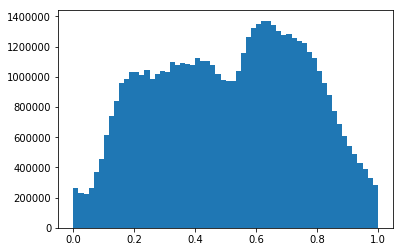

In [15]:
plt.hist(temporal_features.day_progress, bins=60)
print(temporal_features.day_progress.describe())

count    5.542386e+07
mean     3.027075e-01
std      3.191864e-01
min      0.000000e+00
25%      2.506945e-01
50%      5.091270e-01
75%      7.440476e-01
max      9.999008e-01
Name: week_progress, dtype: float64


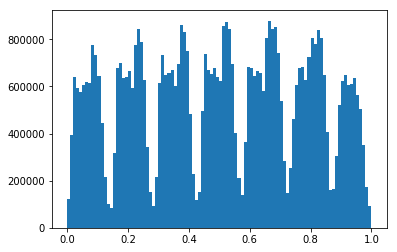

In [16]:
plt.hist(temporal_features.week_progress, bins=100)
print(temporal_features.week_progress.describe())

count    5.542386e+07
mean     3.027075e-01
std      3.264571e-01
min      0.000000e+00
25%      2.556482e-01
50%      4.994848e-01
75%      7.452778e-01
max      9.999776e-01
Name: month_progress, dtype: float64


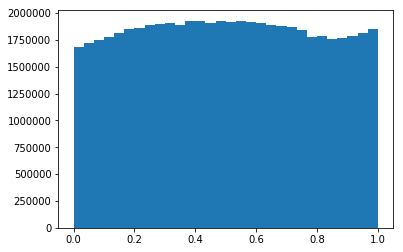

In [17]:
plt.hist(temporal_features.month_progress, bins=30)
print(temporal_features.month_progress.describe())

count    5.542386e+07
mean     3.027075e-01
std      3.167471e-01
min      0.000000e+00
25%      2.319559e-01
50%      4.563128e-01
75%      7.305003e-01
max      9.999981e-01
Name: year_progress, dtype: float64


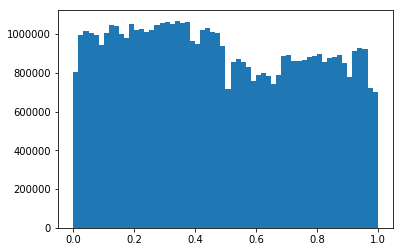

In [18]:
plt.hist(temporal_features.year_progress, bins=60)
print(temporal_features.year_progress.describe())

# In progress: holiday

In [19]:
import holidays
newyork_holidays = holidays.CountryHoliday('US', state='NY')

In [20]:
datetime.date(2015, 1, 1) in newyork_holidays

True

In [21]:
HOLIDAY_TO_CODE = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Election Day', 'Independence Day', 'Independence Day (Observed)', 'Labor Day', "Lincoln's Birthday", "Lincoln's Birthday (Observed)", 'Martin Luther King, Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Susan B. Anthony Day', 'Thanksgiving', 'Veterans Day', 'Veterans Day (Observed)', "Washington's Birthday", "Washington's Birthday, Susan B. Anthony Day"]
CODE_TO_HOLLIDAY = {i + 1: name for i, name in enumerate(HOLIDAY_TO_CODE)}
HOLIDAY_TO_CODE = {name: i + 1 for i, name in enumerate(HOLIDAY_TO_CODE)}

for y in range(2009, 2016):
    for m in range(1, 13):
        for d in range(1, 32):
            try:
                name = newyork_holidays.get(datetime.date(y, m, d))
            except ValueError:
                break

In [22]:
HOLIDAY_TO_CODE = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Election Day', 'Independence Day', 'Independence Day (Observed)', 'Labor Day', "Lincoln's Birthday", "Lincoln's Birthday (Observed)", 'Martin Luther King, Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Susan B. Anthony Day', 'Thanksgiving', 'Veterans Day', 'Veterans Day (Observed)', "Washington's Birthday", "Washington's Birthday, Susan B. Anthony Day"]
CODE_TO_HOLLIDAY = {i + 1: name for i, name in enumerate(HOLIDAY_TO_CODE)}
HOLIDAY_TO_CODE = {name: i + 1 for i, name in enumerate(HOLIDAY_TO_CODE)}

In [23]:
CODE_TO_HOLLIDAY

{1: 'Christmas Day',
 2: 'Christmas Day (Observed)',
 3: 'Columbus Day',
 4: 'Election Day',
 5: 'Independence Day',
 6: 'Independence Day (Observed)',
 7: 'Labor Day',
 8: "Lincoln's Birthday",
 9: "Lincoln's Birthday (Observed)",
 10: 'Martin Luther King, Jr. Day',
 11: 'Memorial Day',
 12: "New Year's Day",
 13: "New Year's Day (Observed)",
 14: 'Susan B. Anthony Day',
 15: 'Thanksgiving',
 16: 'Veterans Day',
 17: 'Veterans Day (Observed)',
 18: "Washington's Birthday",
 19: "Washington's Birthday, Susan B. Anthony Day"}

# Testing

In [69]:
from sklearn.pipeline import Pipeline

In [78]:
pip = Pipeline([('test', utils.BasicTemporalFeatures())])

In [79]:
pip.transform(test)

,timestamp,minute,hour,day,month,year,dayofweek,dayofyear,days_in_month,is_leap_year,day_progress,week_progress,month_progress,year_progress
0,1422364104,8,8,27,1,2015,1,27,31,False,0.338889,0.191270,0.849642,0.072161
1,1422364104,8,8,27,1,2015,1,27,31,False,0.338889,0.191270,0.849642,0.072161
2,1318074824,53,7,8,10,2011,5,281,31,False,0.328472,0.761210,0.236402,0.768023
3,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
4,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
5,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
6,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
7,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
8,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
9,1392736940,22,10,18,2,2014,1,49,28,False,0.431944,0.204563,0.622569,0.132690


In [77]:
utils.BasicTemporalFeatures().transform(test)

,timestamp,minute,hour,day,month,year,dayofweek,dayofyear,days_in_month,is_leap_year,day_progress,week_progress,month_progress,year_progress
0,1422364104,8,8,27,1,2015,1,27,31,False,0.338889,0.191270,0.849642,0.072161
1,1422364104,8,8,27,1,2015,1,27,31,False,0.338889,0.191270,0.849642,0.072161
2,1318074824,53,7,8,10,2011,5,281,31,False,0.328472,0.761210,0.236402,0.768023
3,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
4,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
5,1354396332,12,16,1,12,2012,5,336,31,True,0.675000,0.810714,0.021774,0.917145
6,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
7,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
8,1317903020,10,8,6,10,2011,3,279,31,False,0.340278,0.477183,0.172267,0.762576
9,1392736940,22,10,18,2,2014,1,49,28,False,0.431944,0.204563,0.622569,0.132690


In [80]:
est = utils.BasicTemporalFeatures()

In [90]:
est.get_params()

{'feature_names': ('timestamp',
  'minute',
  'hour',
  'day',
  'month',
  'year',
  'dayofweek',
  'dayofyear',
  'days_in_month',
  'is_leap_year',
  'day_progress',
  'week_progress',
  'month_progress',
  'year_progress')}

In [89]:
est.set_params(feature_names = None)

BasicTemporalFeatures(feature_names=('timestamp', 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'days_in_month', 'is_leap_year', 'day_progress', 'week_progress', 'month_progress', 'year_progress'))

<module 'nytf.utils' from '..\\nytf\\utils.py'>

d:\Profiles\thaugomat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Profiles\thaugomat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.4824049 , -0.22377172,  0.20418478, ..., -0.00350338,
         1.66312028, -0.72454147],
       [-1.18246717,  1.28077047, -0.13757567, ..., -0.02157309,
         0.87022405,  0.61652961],
       [-0.31589749,  0.29703135,  1.40034638, ...,  0.02122584,
        -1.46376516, -0.59476042],
       ...,
       [ 1.15711305, -0.62884077,  0.37506501, ..., -0.12427165,
        -0.69463778,  1.76292916],
       [-0.5661452 , -1.14964383,  0.54594524, ..., -0.43895299,
        -0.69463778,  0.18392602],
       [-0.17973349,  1.68583952, -0.47933613, ..., -0.16319027,
        -0.30638495,  1.82781974]])